In [2]:
import psycopg2
import pandas as pd
import psycopg2.extras
import matplotlib.pyplot as plt

In [3]:
class PostgresConnection(object):
    def __init__(self):
        self.connection = psycopg2.connect(database="ecomdb",
                                           user = "postgres",
                                           password = "123456",
                                           host = "127.0.0.1",
                                           port = "5432")

    def getConnection(self):
        print("successfully connected to database")
        return self.connection
    
    
# con = PostgresConnection().getConnection()    

### Common Function to fetch Data from all tables 

In [4]:
#  select_stmt= is the SQL select query along with  table and column name    
def retrive_data_from_table(select_stmt): 
    con = PostgresConnection().getConnection()
    cur = con.cursor()
#     select_stmt = "SELECT t.payment_key , t.trans_type, t.bank_name " \
#                   "FROM ecomdb_star_schema.trans_dim t"
    cur.execute(select_stmt)
    records = cur.fetchall()
    return records

# Do some simple CUBE query including ROLL UP, DRILL DOWN, SLICE, DICE to answer the following questions from the ecomdb warehouse

### Q1: Find the division/district/year/month wise total_sale_price joining fact table and respective dimension table 

##### ROLLUP

In [26]:
select_stmt = " SELECT sr.division ,sr.district,tim.month, tim.year, SUM(fact.total_price) " \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " JOIN ecomdb_star_schema.time_dim tim on tim.time_key=fact.time_key "\
              " GROUP BY ROLLUP (sr.division,sr.district,tim.month, tim.year) "\
              " ORDER BY sr.division"

ROLLUP_records = retrive_data_from_table(select_stmt)
df = pd.DataFrame(list(ROLLUP_records), columns=['division', 'district', 'month', 'year', 'total_sales'])
df

successfully connected to database


,division,district,month,year,total_sales
0,BARISAL,JHALOKATI,3.0,2018.0,13597.50
1,BARISAL,BARISAL,1.0,2021.0,51799.00
2,BARISAL,BARGUNA,12.0,2018.0,23065.50
3,BARISAL,PATUAKHALI,5.0,2015.0,25013.50
4,BARISAL,PATUAKHALI,11.0,2017.0,23102.50
...,...,...,...,...,...
6275,SYLHET,MAULVIBAZAR,12.0,2020.0,27745.00
6276,SYLHET,MAULVIBAZAR,8.0,2017.0,31631.50
6277,SYLHET,MAULVIBAZAR,10.0,2015.0,24893.50
6278,SYLHET,HABIGANJ,10.0,2020.0,29836.00


In [27]:
print(df.dtypes)

division        object
district        object
month          float64
year           float64
total_sales     object
dtype: object


In [28]:
df['total_sales'] = df['total_sales'].astype('float64')
print(df.dtypes)

division        object
district        object
month          float64
year           float64
total_sales    float64
dtype: object


##### DRILL DOWN-Q-1

In [133]:
## DRILL_DOWN == Make Specific or expand to all category

## Here I tried to expand TIME_DIM table
## DRILL_DOWN(division->> upazila)
select_stmt1 = " SELECT sr.division, sr.district, sr.upazila,tim.year, SUM(fact.total_price) " \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " JOIN ecomdb_star_schema.time_dim tim on tim.time_key=fact.time_key "\
              " GROUP BY CUBE(sr.division,sr.district,sr.upazila, tim.year) "\
              " ORDER BY sr.division"
CUBE_records = retrive_data_from_table(select_stmt1)
df1 = pd.DataFrame(list(CUBE_records), columns=['division', 'district','upazila', 'year', 'total_sales'])
print(df1)


## Here I tried to expand TIME_DIM table
## DRILL_DOWN(division->> upazila)
select_stmt2 = " SELECT sr.division,tim.year,tim.month,tim.quarter, SUM(fact.total_price) " \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " JOIN ecomdb_star_schema.time_dim tim on tim.time_key=fact.time_key "\
              " GROUP BY CUBE(sr.division,tim.year,tim.month,tim.quarter) "\
              " ORDER BY sr.division"


CUBE_records2 = retrive_data_from_table(select_stmt2)
df2 = pd.DataFrame(list(CUBE_records2), columns=['division','year','month','quarter', 'total_sales'])
print(df2)

successfully connected to database
      division     district      upazila    year total_sales
0      BARISAL    JHALOKATI         None  2015.0   157612.00
1      BARISAL      BARISAL  BANARI PARA  2014.0    82468.00
2      BARISAL      BARISAL  MEHENDIGANJ  2020.0    81596.00
3      BARISAL   PATUAKHALI    RANGABALI  2021.0     3318.50
4      BARISAL      BARISAL   AGAILJHARA  2015.0    83466.00
...        ...          ...          ...     ...         ...
21055     None   PANCHAGARH         None  2021.0    10391.00
21056     None  LALMONIRHAT         None  2020.0   206774.50
21057     None    GAIBANDHA         None  2021.0    18908.00
21058     None  LALMONIRHAT         None  2019.0   212435.50
21059     None     RAJSHAHI         None  2017.0  1078581.50

[21060 rows x 5 columns]
successfully connected to database
     division    year  month quarter total_sales
0     BARISAL  2019.0   10.0      Q4   179156.50
1     BARISAL  2017.0    1.0      Q1   184557.00
2     BARISAL  2016.0    

##### CUBE_Q-1

In [30]:
select_stmt = " SELECT sr.division ,sr.district,tim.month, tim.year, SUM(fact.total_price) " \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " JOIN ecomdb_star_schema.time_dim tim on tim.time_key=fact.time_key "\
              " GROUP BY CUBE(sr.division,sr.district,tim.month, tim.year) "\
              " ORDER BY sr.division"
  
CUBE_records = retrive_data_from_table(select_stmt)
df = pd.DataFrame(list(CUBE_records), columns=['division', 'district', 'month', 'year', 'total_sales'])
df

successfully connected to database


,division,district,month,year,total_sales
0,BARISAL,PIROJPUR,9.0,2015.0,24391.00
1,BARISAL,None,8.0,NaN,1263763.00
2,BARISAL,PIROJPUR,10.0,2014.0,22612.00
3,BARISAL,PIROJPUR,11.0,2015.0,22048.00
4,BARISAL,PIROJPUR,8.0,NaN,175170.00
...,...,...,...,...,...
14411,None,PANCHAGARH,NaN,2021.0,10391.00
14412,None,LALMONIRHAT,NaN,2020.0,206774.50
14413,None,GAIBANDHA,NaN,2021.0,18908.00
14414,None,LALMONIRHAT,NaN,2019.0,212435.50


In [33]:
df['division'].unique()

array(['BARISAL', 'CHITTAGONG', 'DHAKA', 'KHULNA', 'RAJSHAHI', 'RANGPUR',
       'SYLHET', None], dtype=object)

In [32]:
df.dtypes
df['total_sales'] = df['total_sales'].astype('float64')
df.dtypes

division        object
district        object
month          float64
year           float64
total_sales    float64
dtype: object

##### SLICE_Q-1

In [98]:
# SLICE for divsion
select_stmt = " SELECT sr.division, sr.district, SUM(fact.total_price)" \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " Where sr.division ='CHITTAGONG' " \
              " GROUP BY sr.division,sr.district"
 
SLICE_records = retrive_data_from_table(select_stmt)
df = pd.DataFrame(list(SLICE_records), columns=['division','district', 'total_sales'])
df

successfully connected to database


,division,district,total_sales
0,CHITTAGONG,BANDARBAN,1990721.50
1,CHITTAGONG,BRAHMANBARIA,2656468.50
2,CHITTAGONG,CHANDPUR,2306553.50
3,CHITTAGONG,CHITTAGONG,14585971.00
4,CHITTAGONG,COMILLA,4573796.50
5,CHITTAGONG,COX'S BAZAR,2376257.50
6,CHITTAGONG,FENI,1695747.00
7,CHITTAGONG,KHAGRACHHARI,2323443.00
8,CHITTAGONG,LAKSHMIPUR,1459818.50
9,CHITTAGONG,NOAKHALI,2642373.50


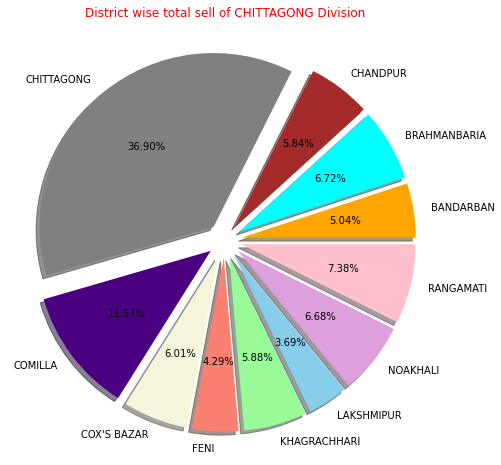

In [129]:
labels=df['district']
data = df['total_sales']
textprops = {"fontsize":10}
colors = ( "orange", "cyan", "brown", "grey", "indigo", "beige",'salmon','palegreen','skyblue','plum','pink')
plt.title('District wise total sell of CHITTAGONG Division',loc='center',color='r')

plt.pie(data, labels=labels, shadow = True, textprops = textprops, colors=colors, autopct='%.2f%%',explode=(0.1, 0.1,0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1, 0.1))
# plt.figure(figsize=(20,12)) 
plt.rcParams["figure.figsize"] = (12,7)
plt.show()


##### DICE_Q1

In [78]:
# select_stmt1 = " SELECT i.item_name,SUM(f.total_price)" \
#               " From ecomdb_star_schema.fact_table f " \
#               " JOIN ecomdb_star_schema.store_dim s on s.store_key=f.store_key " \
#               "JOIN ecomdb_star_schema.item_dim i on i.item_key=f.item_key" \
#               " Where i.item_name ='Cherry Coke 12oz' " \
#               " GROUP BY i.item_name "

select_stmt = " SELECT sr.division, tim.month, SUM(fact.total_price)" \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " JOIN ecomdb_star_schema.time_dim tim on tim.time_key=fact.time_key "\
              " Where sr.division ='CHITTAGONG' " \
              " GROUP BY sr.division, tim.month"
 
SLICE_records = retrive_data_from_table(select_stmt)
df_slice = pd.DataFrame(list(SLICE_records), columns=['division','month', 'total_sales'])
df_slice

successfully connected to database


,division,month,total_sales
0,CHITTAGONG,1,3429666.50
1,CHITTAGONG,2,3010753.00
2,CHITTAGONG,3,3368062.00
3,CHITTAGONG,4,3168166.00
4,CHITTAGONG,5,3443851.00
5,CHITTAGONG,6,3179065.00
6,CHITTAGONG,7,3425908.50
7,CHITTAGONG,8,3335373.50
8,CHITTAGONG,9,3255130.50
9,CHITTAGONG,10,3300710.50


    month total_sales
0       1  3429666.50
1       2  3010753.00
2       3  3368062.00
3       4  3168166.00
4       5  3443851.00
5       6  3179065.00
6       7  3425908.50
7       8  3335373.50
8       9  3255130.50
9      10  3300710.50
10     11  3280227.50
11     12  3330276.00


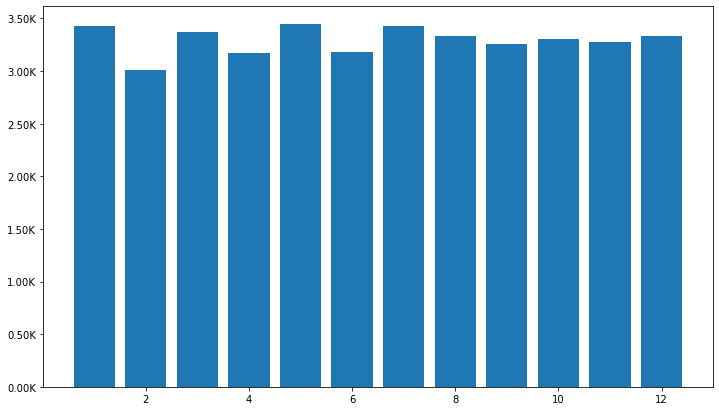

In [146]:
print(df_slice)
total_sales= df_slice['total_sales']
month =df_slice['month']

def millions(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.2f}K'.format(x*1e-6)   

fig, ax = plt.subplots()
# Use automatic FuncFormatter creation
ax.yaxis.set_major_formatter(millions)
ax.bar(month, total_sales)
plt.show()

### Q2: Find the customer/bank/transaction(cash/online) wise total_sale_price joining fact table and respective dimension table 

##### ROLLUP-Q2

In [179]:
select_stmt = " SELECT c.coustomer_key, c.name, trs.trans_type, trs.bank_name, SUM(fact.total_price) "\
              " From ecomdb_star_schema.fact_table fact "\
              " JOIN ecomdb_star_schema.trans_dim trs on trs.payment_key = fact.payment_key "\
              " JOIN ecomdb_star_schema.coustomer_dim c on c.coustomer_key = fact.coustomer_key "\
              " GROUP BY ROLLUP (trs.trans_type, trs.bank_name, c.coustomer_key,c.name) "
 

ROLLUP_records = retrive_data_from_table(select_stmt)
df = pd.DataFrame(list(ROLLUP_records), columns=['customer_key', 'Customer_name', 'trans_type', 'bank_name', 'total_sales'])
df

successfully connected to database


,customer_key,Customer_name,trans_type,bank_name,total_sales
0,C000001,sumit,card,AB Bank Limited,1011.50
1,C000001,None,card,AB Bank Limited,1011.50
2,C000003,kailash kumar,card,AB Bank Limited,56.0
3,C000003,None,card,AB Bank Limited,56.0
4,C000004,bhagwati prasad,card,AB Bank Limited,1530.0
...,...,...,...,...,...
673232,C009191,roopa,mobile,Rocket,24.0
673233,C009191,None,mobile,Rocket,24.0
673234,None,None,mobile,Rocket,5441949.00
673235,None,None,mobile,None,16219763.00


In [180]:
df['trans_type'].unique()

array(['card', 'cash', 'mobile', None], dtype=object)

In [149]:
df['bank_name'].unique()

array(['AB Bank Limited', 'Bangladesh Commerce Bank Limited',
       'Bank Asia Limited', 'Bengal Commercial Bank Ltd',
       'BRAC Bank Limited', 'Citizens Bank Limited', 'City Bank Limited',
       'Community Bank Bangladesh Limited', 'Dhaka Bank Limited',
       'Dutch-Bangla Bank Limited', 'Eastern Bank Limited',
       'IFIC Bank Limited', 'Jamuna Bank Limited', 'Meghna Bank Limited',
       'Mercantile Bank Limited', 'Midland Bank Limited',
       'Modhumoti Bank Limited', 'Mutual Trust Bank Limited',
       'National Bank Limited', 'National Credit & Commerce Bank Limited',
       'NRB Bank Limited', 'NRB Commercial Bank Ltd',
       'NRB Global Bank Ltd', 'One Bank Limited', 'Padma Bank Limited',
       'Premier Bank Limited', 'Prime Bank Limited',
       'Pubali Bank Limited', 'Shimanto Bank Ltd',
       'South Bangla Agriculture and Commerce Bank Limited',
       'Southeast Bank Limited', 'Standard Bank Limited',
       'Trust Bank Limited', 'United Commercial Bank Ltd',
   

In [ ]:
dfTT =df.groupby(['trans_type']).sum()
# dfBN =df2.groupby(['bank_name']).sum()
# dfTB =df2.groupby(['trans_type','bank_name']).sum()
 
dfTT 


In [ ]:
# labels=df['trans_type']
# data = df['total_sales']
# textprops = {"fontsize":10}
# colors = ( "orange", "cyan", "brown", "grey", "indigo", "beige",'salmon','palegreen','skyblue','plum','pink')
# plt.title('District wise total sell of CHITTAGONG Division',loc='center',color='r')

# plt.pie(data, labels=labels, shadow = True, textprops = textprops, colors=colors, autopct='%.2f%%',explode=(0.1, 0.1,0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1, 0.1))
# # plt.figure(figsize=(20,12)) 
# plt.rcParams["figure.figsize"] = (12,7)
# plt.show()

##### DRILL DOWN_Q2

In [155]:
## DRILL_DOWN == Make Specific or expand to all category

## Here I tried to expand TIME_DIM table
## DRILL_DOWN(division->> upazila)
select_stmt1 = " SELECT sr.division, sr.district, sr.upazila, trs.trans_type, trs.bank_name, SUM(fact.total_price) " \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " JOIN ecomdb_star_schema.trans_dim trs on trs.payment_key = fact.payment_key "\
              " GROUP BY CUBE(sr.division,sr.district,sr.upazila,trs.trans_type, trs.bank_name) "\
              " ORDER BY sr.division"
CUBE_records = retrive_data_from_table(select_stmt1)
df1 = pd.DataFrame(list(CUBE_records), columns=['division', 'district','upazila', 'trans_type','bank_name','total_sales'])
print(df1)

successfully connected to database
       division district                  upazila trans_type  \
0       BARISAL  BARISAL              MEHENDIGANJ       card   
1       BARISAL     None  BARISAL SADAR (KOTWALI)       card   
2       BARISAL  BARISAL                   MULADI       card   
3       BARISAL     None  BARISAL SADAR (KOTWALI)       card   
4       BARISAL  BARISAL                 WAZIRPUR       card   
...         ...      ...                      ...        ...   
191875     None     None                KANTHALIA       None   
191876     None     None                  KAPASIA       card   
191877     None     None                 PAKUNDIA     mobile   
191878     None     None                  KAPASIA       card   
191879     None     None                 PAKUNDIA     mobile   

                               bank_name total_sales  
0                                   None   522580.00  
1                     Trust Bank Limited    10720.50  
2                              

In [154]:
## Here I tried to expand TIME_DIM table
## DRILL_DOWN(year->> quarter)
select_stmt2 = " SELECT tim.year,tim.month,tim.quarter, trs.trans_type, trs.bank_name, SUM(fact.total_price) " \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.trans_dim trs on trs.payment_key = fact.payment_key "\
              " JOIN ecomdb_star_schema.time_dim tim on tim.time_key = fact.time_key "\
              " GROUP BY CUBE(tim.year,tim.month,tim.quarter, trs.trans_type, trs.bank_name) "
               
CUBE_records2 = retrive_data_from_table(select_stmt2)
df2 = pd.DataFrame(list(CUBE_records2), columns=['year', 'month', 'quarter','trans_type', 'bank_name', 'total_sales'])
print(df2)

successfully connected to database
         year  month quarter trans_type bank_name total_sales
0      2014.0    1.0      Q1       card      None   889170.00
1      2014.0    1.0    None       card      None   889170.00
2      2014.0    2.0      Q1       card      None  2013367.50
3      2014.0    2.0    None       card      None  2013367.50
4      2014.0    3.0      Q1       card      None  2272527.00
...       ...    ...     ...        ...       ...         ...
19347  2019.0    1.0      Q1       None      None  2683734.00
19348  2019.0    7.0      Q3       None      None  2583219.50
19349  2019.0    2.0      Q1       None      None  2299017.00
19350  2015.0    6.0      Q2       None      None  2433905.50
19351  2018.0   11.0      Q4       None      None  2470402.50

[19352 rows x 6 columns]


In [173]:
df2['year'].unique()

array([2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021.,   nan])

In [178]:
df2['bank_name'].unique()

array([None, 'AB Bank Limited', 'Bangladesh Commerce Bank Limited',
       'Bank Asia Limited', 'Bengal Commercial Bank Ltd',
       'BRAC Bank Limited', 'Citizens Bank Limited', 'City Bank Limited',
       'Community Bank Bangladesh Limited', 'Dhaka Bank Limited',
       'Dutch-Bangla Bank Limited', 'Eastern Bank Limited',
       'IFIC Bank Limited', 'Jamuna Bank Limited', 'Meghna Bank Limited',
       'Mercantile Bank Limited', 'Midland Bank Limited',
       'Modhumoti Bank Limited', 'Mutual Trust Bank Limited',
       'National Bank Limited', 'National Credit & Commerce Bank Limited',
       'NRB Bank Limited', 'NRB Commercial Bank Ltd',
       'NRB Global Bank Ltd', 'One Bank Limited', 'Padma Bank Limited',
       'Premier Bank Limited', 'Prime Bank Limited',
       'Pubali Bank Limited', 'Shimanto Bank Ltd',
       'South Bangla Agriculture and Commerce Bank Limited',
       'Southeast Bank Limited', 'Standard Bank Limited',
       'Trust Bank Limited', 'United Commercial Bank Ltd

In [177]:
# dfTT =df2.groupby(['trans_type ']).sum()
# dfBN =df2.groupby(['bank_name']).sum()
# dfTB =df2.groupby(['trans_type','bank_name']).sum()

dfYB =df2.groupby(['year','bank_name']).sum()
dfYB1=dfYB.query("year == 2015.0")
dfYB1 


month
year   bank_name                                                
2015.0 AB Bank Limited                                     312.0
       BRAC Bank Limited                                   312.0
       Bangladesh Commerce Bank Limited                    312.0
       Bank Asia Limited                                   312.0
       Bengal Commercial Bank Ltd                          312.0
       Bkash                                               312.0
       Citizens Bank Limited                               312.0
       City Bank Limited                                   312.0
       Community Bank Bangladesh Limited                   312.0
       Dhaka Bank Limited                                  312.0
       Dutch-Bangla Bank Limited                           312.0
       Eastern Bank Limited                                312.0
       IFIC Bank Limited                                   312.0
       Jamuna Bank Limited                                 312.0
       Meghna Bank Limited                                 312.0
       Mercantile Bank Limited                             312.0
       Midland Bank Limited                                312.0
       Modhumoti Bank Limited                              312.0
       Mutual Trust Bank Limited                           312.0
       NRB Bank Limited                                    312.0
       NRB Commercial Bank Ltd                             312.0
       NRB Global Bank Ltd                                 312.0
       Nagad                                               312.0
       National Bank Limited                               312.0
       National Credit & Commerce Bank Limited             312.0
       None                                                312.0
       One Bank Limited                                    312.0
       Padma Bank Limited                                  312.0
       Premier Bank Limited                                312.0
       Prime Bank Limited                                  312.0
       Pubali Bank Limited                                 312.0
       Rocket                                              312.0
       Shimanto Bank Ltd                                   312.0
       South Bangla Agriculture and Commerce Bank Limited  312.0
       Southeast Bank Limited                              312.0
       Standard Bank Limited                               312.0
       Trust Bank Limited                                  312.0
       United Commercial Bank Ltd                          312.0
       Uttara Bank Limited                                 312.0

##### CUBE-Q2

In [12]:
select_stmt = " SELECT cs.coustomer_key, trs.trans_type, trs.bank_name, SUM(fact.total_price) "\
              " From ecomdb_star_schema.fact_table fact "\
              " JOIN ecomdb_star_schema.coustomer_dim cs on cs.coustomer_key = fact.coustomer_key "\
              " JOIN ecomdb_star_schema.trans_dim trs on trs.payment_key = fact.payment_key "\
              " GROUP BY CUBE(cs.coustomer_key, trs.trans_type, trs.bank_name) "\
              " ORDER BY cs.coustomer_key "

CUBE_records = retrive_data_from_table(select_stmt)
df = pd.DataFrame(list(CUBE_records), columns=['coustomer_key', 'trans_type', 'bank_name', 'total_sales'])
df

successfully connected to database


,coustomer_key,trans_type,bank_name,total_sales
0,C000001,None,None,516.0
1,C000001,None,NRB Bank Limited,325.00
2,C000001,None,NRB Global Bank Ltd,192.0
3,C000001,None,NRB Commercial Bank Ltd,592.0
4,C000001,None,Padma Bank Limited,244.0
...,...,...,...,...
709478,None,None,Southeast Bank Limited,5382551.50
709479,None,None,Trust Bank Limited,5441614.00
709480,None,None,United Commercial Bank Ltd,5393709.50
709481,None,None,South Bangla Agriculture and Commerce Bank Lim...,5456230.50


In [39]:
df.isna().sum()

coustomer_key        82
trans_type       345828
bank_name         36211
total_sales           0
dtype: int64

In [15]:
# dfTB =df.groupby(['trans_type','bank_name']).sum()
# dfTT =df.groupby(['trans_type ']).sum()

dfBN =df.groupby(['bank_name']).sum()
# sum_df = df.groupby(['bank_name']).agg({'total_sales': 'sum'})
dfBN

,total_sales
bank_name,
AB Bank Limited,21828124.00
BRAC Bank Limited,21646366.00
Bangladesh Commerce Bank Limited,21847994.00
Bank Asia Limited,21497142.00
Bengal Commercial Bank Ltd,21636434.00
Bkash,21514820.00
Citizens Bank Limited,21785722.00
City Bank Limited,21711620.00
Community Bank Bangladesh Limited,21486012.00


In [22]:
dfBN1 = df.groupby('bank_name')['total_sales'].agg(['sum','count'])
dfBN1

,sum,count
bank_name,,
AB Bank Limited,21828124.00,17326
BRAC Bank Limited,21646366.00,17200
Bangladesh Commerce Bank Limited,21847994.00,17302
Bank Asia Limited,21497142.00,17302
Bengal Commercial Bank Ltd,21636434.00,17300
Bkash,21514820.00,17346
Citizens Bank Limited,21785722.00,17232
City Bank Limited,21711620.00,17250
Community Bank Bangladesh Limited,21486012.00,17218


In [27]:
dfBN1.columns

Index(['sum', 'count'], dtype='object')

In [36]:
labels = []
for name in df['bank_name'].unique():
    labels.append(name)
print(labels)
labels1 = sorted(labels, key=str.lower)
print(labels1)

['None', 'NRB Bank Limited', 'NRB Global Bank Ltd', 'NRB Commercial Bank Ltd', 'Padma Bank Limited', 'Pubali Bank Limited', 'Premier Bank Limited', 'One Bank Limited', 'Prime Bank Limited', 'Standard Bank Limited', 'United Commercial Bank Ltd', 'Trust Bank Limited', 'Bank Asia Limited', 'Bengal Commercial Bank Ltd', 'Bangladesh Commerce Bank Limited', 'AB Bank Limited', 'Shimanto Bank Ltd', 'Rocket', 'BRAC Bank Limited', 'City Bank Limited', 'Bkash', 'Citizens Bank Limited', 'Community Bank Bangladesh Limited', 'Dhaka Bank Limited', 'Dutch-Bangla Bank Limited', 'IFIC Bank Limited', 'Eastern Bank Limited', 'Midland Bank Limited', 'Modhumoti Bank Limited', 'Jamuna Bank Limited', 'Meghna Bank Limited', 'Mercantile Bank Limited', 'Mutual Trust Bank Limited', 'National Bank Limited', None, 'Nagad', 'National Credit & Commerce Bank Limited', 'South Bangla Agriculture and Commerce Bank Limited', 'Southeast Bank Limited', 'Uttara Bank Limited']


TypeError: descriptor 'lower' for 'str' objects doesn't apply to a 'NoneType' object

ValueError: 'label' must be of length 'x'

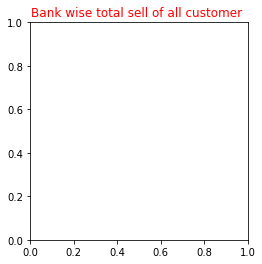

In [29]:
labels=dfBN1['bank_name']
data = dfBN1['sum']
textprops = {"fontsize":10}
# colors = ( "orange", "cyan", "brown", "grey", "indigo", "beige",'salmon','palegreen','skyblue','plum','pink')
# colors=colors, explode=(0.1, 0.1,0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1, 0.1)
plt.title('Bank wise total sell of all customer ', loc='center', color='r')

plt.pie(data, labels=labels, shadow = True, textprops = textprops,  autopct='%.2f%%')
plt.rcParams["figure.figsize"] = (12,7)
plt.show()

In [14]:
dfBN_NRB=dfBN.query("bank_name == 'NRB Bank Limited'")
dfBN_NRB 

,total_sales
bank_name,
NRB Bank Limited,21692762.00


In [ ]:
df.dtypes
df['total_sales'] = df['total_sales'].astype('float64')
df.dtypes

##### SLICE_Q2

In [ ]:
# SLICE for divsion
select_stmt = " SELECT sr.division, sr.district, SUM(fact.total_price)" \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " Where sr.division ='CHITTAGONG' " \
              " GROUP BY sr.division,sr.district"
 
SLICE_records = retrive_data_from_table(select_stmt)
df = pd.DataFrame(list(SLICE_records), columns=['division','district', 'total_sales'])
df

In [ ]:
labels=df['district']
data = df['total_sales']
textprops = {"fontsize":10}
colors = ( "orange", "cyan", "brown", "grey", "indigo", "beige",'salmon','palegreen','skyblue','plum','pink')
plt.title('District wise total sell of CHITTAGONG Division',loc='center',color='r')

plt.pie(data, labels=labels, shadow = True, textprops = textprops, colors=colors, autopct='%.2f%%',explode=(0.1, 0.1,0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1, 0.1))
# plt.figure(figsize=(20,12)) 
plt.rcParams["figure.figsize"] = (12,7)
plt.show()

##### DICE_Q2

In [ ]:
# select_stmt1 = " SELECT i.item_name,SUM(f.total_price)" \
#               " From ecomdb_star_schema.fact_table f " \
#               " JOIN ecomdb_star_schema.store_dim s on s.store_key=f.store_key " \
#               "JOIN ecomdb_star_schema.item_dim i on i.item_key=f.item_key" \
#               " Where i.item_name ='Cherry Coke 12oz' " \
#               " GROUP BY i.item_name "

select_stmt = " SELECT sr.division, tim.month, SUM(fact.total_price)" \
              " From ecomdb_star_schema.fact_table fact " \
              " JOIN ecomdb_star_schema.store_dim sr on sr.store_key=fact.store_key " \
              " JOIN ecomdb_star_schema.time_dim tim on tim.time_key=fact.time_key "\
              " Where sr.division ='CHITTAGONG' " \
              " GROUP BY sr.division, tim.month"
 
SLICE_records = retrive_data_from_table(select_stmt)
df_slice = pd.DataFrame(list(SLICE_records), columns=['division','month', 'total_sales'])
df_slice

In [ ]:
# 
# df_slice.drop(['division'],axis=1, inplace=True) 
print(df_slice)
df_slice.plot(kind='bar', figsize=(10,7))

### Q3: Total sales in Barisal

In [54]:
select_query =  "Select t2.division, sum(t1.total_price) "\
            "from ecomdb_star_schema.fact_table t1 "\
            "join ecomdb_star_schema.store_dim t2 on t1.store_key = t2.store_key "\
            "where t2.division = 'BARISAL' "\
            "group by(t2.division)"

record_Q3 = retrive_data_from_table(select_query)
df_Q3 = pd.DataFrame(list(record_Q3), columns=['year', 'total_price'])
df_Q3


successfully connected to database


,year,total_price
0,BARISAL,15040687.50


### Q4: Total sales in 2015

In [52]:
select_query=  "select  t2.year, sum(t1.total_price) "\
                "from ecomdb_star_schema.fact_table t1 "\
                "join ecomdb_star_schema.time_dim t2 on t1.time_key = t2.time_key "\
                "where t2.year= 2015 " \
                "group by(t2.year)"

record_Q4 = retrive_data_from_table(select_query)
df_Q4 = pd.DataFrame(list(record_Q4), columns=['year', 'total_price'])
df_Q4

successfully connected to database


,year,total_price
0,2015,30191440.50


### Q5: Total sales of Barisal in 2015

In [49]:
select_query =  "select t3.division, t2.year, sum(t1.total_price) " \
                "from ecomdb_star_schema.fact_table t1 " \
                "join ecomdb_star_schema.time_dim t2 on t1.time_key = t2.time_key " \
                "join ecomdb_star_schema.store_dim t3 on t1.store_key = t3.store_key " \
                "where  t2.year= 2015 and t3.division = 'BARISAL'  " \
                "group by (t3.division, t2.year)"

record_Q5 = retrive_data_from_table(select_query)
df_Q5 = pd.DataFrame(list(record_Q5), columns=['division','year', 'total_price'])
df_Q5


successfully connected to database


,division,year,total_price
0,BARISAL,2015,2153805.50


In [45]:
df_Q5.dtypes

division       object
year            int64
total_price    object
dtype: object

# Do some complex CUBE query including ROLL UP, DRILL DOWN, SLICE, DICE to answer the following questions from the ecomdb warehouse

### Q6: For each store(item supplier), what are the top three products offered that are most often purchased?

#### S1-> item1 -> quantity_sales
#### S1-> item2 -> quantity_sales
#### S1-> item3 -> quantity_sales

In [72]:
select_query =  "select st.store_key, it.supplier, it.item_key, sum(fact.quantity) as total_sell_quantity "\
                "from ecomdb_star_schema.fact_table fact "\
                "join ecomdb_star_schema.store_dim st on st.store_key = fact.store_key "\
                "join ecomdb_star_schema.item_dim it on it.item_key = fact.item_key "\
                "group by(st.store_key, it.item_key, it.supplier) "\
                "order by( it.item_key,total_sell_quantity)"

record_Q6 = retrive_data_from_table(select_query)
df_Q6 = pd.DataFrame(list(record_Q6), columns=['store', 'supplier', 'item', 'total_sell_quantity'])
df_Q6.head(100)

successfully connected to database


UndefinedColumn: column "total_sell_quantity" does not exist
LINE 1: ... it.item_key, it.supplier) order by( it.item_key, total_sell...
                                                             ^


In [60]:
df_Q6['store'].unique()


array(['S0001', 'S0002', 'S0003', 'S0004', 'S0005', 'S0006', 'S0007',
       'S0008', 'S0009', 'S0010', 'S00100', 'S00101', 'S00102', 'S00103',
       'S00104', 'S00105', 'S00106', 'S00107', 'S00108', 'S00109',
       'S0011', 'S00110', 'S00111', 'S00112', 'S00113', 'S00114',
       'S00115', 'S00116', 'S00117', 'S00118', 'S00119', 'S0012',
       'S00120', 'S00121', 'S00122', 'S00123', 'S00124', 'S00125',
       'S00126', 'S00127', 'S00128', 'S00129', 'S0013', 'S00130',
       'S00131', 'S00132', 'S00133', 'S00134', 'S00135', 'S00136',
       'S00137', 'S00138', 'S00139', 'S0014', 'S00140', 'S00141',
       'S00142', 'S00143', 'S00144', 'S00145', 'S00146', 'S00147',
       'S00148', 'S00149', 'S0015', 'S00150', 'S00151', 'S00152',
       'S00153', 'S00154', 'S00155', 'S00156', 'S00157', 'S00158',
       'S00159', 'S0016', 'S00160', 'S00161', 'S00162', 'S00163',
       'S00164', 'S00165', 'S00166', 'S00167', 'S00168', 'S00169',
       'S0017', 'S00170', 'S00171', 'S00172', 'S00173', 'S

In [66]:
df_Q6['supplier'].unique()

array(['Bolsius Boxmeer', 'CHROMADURLIN S.A.S', 'DENIMACH LTD',
       'HARDFORD AB', 'BIGSO AB', 'Indo Count Industries Ltd',
       'Friedola 1888 GmbH', 'CHERRY GROUP CO.,LTD', 'MAESA SAS',
       'NINGBO SEDUNO IMP & EXP CO.LTD'], dtype=object)

In [ ]:

cur = con.cursor()
select_query = "select  i.supplier,i.item_name,  sum(f.quantity) \
                from ecomdb.fact_table f\
                join ecomdb.item_dim i on f.item_key=i.item_key \
                group by (i.supplier,i.item_name,f.quantity) \
                order by (i.supplier,f.quantity) desc "
cur.execute(select_query)
records = cur.fetchall()
records

query_6 = pd.DataFrame(list(records),columns = ['supplier','item_name','quantity'])
query_6.head()

query_6 = query_6.set_index('item_name').groupby("supplier")['quantity'].nlargest(3).reset_index()
query_6




### Q7: What products have been sold through card or mobile since X days?
#### input: X = 5 days
#### output: [item1, item2, item3, ...........]

In [ ]:
# --- ============== Question 7 ==============
# select distinct t3.item_name 
# from ecomdb_star_schema.fact_table t1 
# join ecomdb_star_schema.trans_dim t2 on t1.payment_key = t2.payment_key
# join ecomdb_star_schema.item_dim t3 on t1.item_key = t3.item_key
# where t2.trans_type= 'card'or t2.trans_type= 'mobile'
 
#  select t1.item_name from ecomdb_star_schema.item_dim t1 where item_key IN(
# 		select t2.item_key from ecomdb_star_schema.fact_table t2  where t2.payment_key IN(
# 			select payment_key from ecomdb_star_schema.item_dim  where trans_type = 'card' or trans_type= 'mobile'

In [ ]:

x = input('enter a number : ')

cur = con.cursor()
# select_query = 
m_1 = "select  i.item_name,\
                tr.trans_type,\
                t.date\
                from ecomdb.fact_table f\
                join ecomdb.item_dim i on f.item_key=i.item_key\
                join ecomdb.trans_dim tr on tr.payment_key = f.payment_key\
                join ecomdb.time_dim t on t.time_key = f.time_key\
                where tr.trans_type = 'card' and t.date > now() - interval ' "
       m_2 = x+"  day'  "
# group by cube(i.item_name,tr.trans_type,t.date) "
# -- order by (i.item_name) desc "
cur.execute(m_1+m_2)
records = cur.fetchall()
records

###  Q8: What season(quarter) is the worst for each product item? As example,
#### item1-> q1
#### item2-> q2

### Q9: Break down the total sales of items geographically (division-wise).
#### item1-> division1->total_sales
#### item1-> division2->total_sales

### Q10: What are the average sales of products sales per store monthly?
#### S1->M1-> avg_sales
#### s1-> M2 -> avg_sales

## Visualization

In [ ]:
cur = con.cursor()
select_stmt = "SELECT s.division, SUM(t.total_price) " \
              "FROM star_schema.fact_table t " \
              "JOIN star_schema.store_dim s on s.store_key=t.store_key " \
                "JOIN star_schema.time_dim tim on tim.time_key=t.time_key " \
                "WHERE tim.month=12 " \
                "GROUP BY s.division " \
                "ORDER BY s.division"
cur.execute(select_stmt)
records = cur.fetchall()
records

In [ ]:
df

In [ ]:
pip install matplotlib

In [ ]:
df = df.set_index(['division'])

In [ ]:
df.plot.pie(y='sales', x='division', figsize=(5, 5))

### PANDAS Techiques:
1. Filter
2. Drop
3. iloc, loc
4. Aggregate
5. Index
6. Column selection, copy, crop
7. Merge, Concate